# Creating plot to see how the number of positive cases changes based on the time in ED

Justifying why we chose the 24 hour time.

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from datetime import timedelta
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [2]:
# read in files
datadir = "../../DataTD/"

adt_file = "{}/cohort_1_3_adt.csv".format(datadir)
cohort_file = "../../OutputTD/1_cohort/1_4_cohort.csv"

adt = pd.read_csv(adt_file)
cohort = pd.read_csv(cohort_file)


/home/eulalio/.local/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3165: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
print(adt.pat_enc_csn_id_coded.nunique())
print(cohort.pat_enc_csn_id_coded.nunique())

# keep only the final cohort in adt table
adjusted_cohort_adt = adt[adt.pat_enc_csn_id_coded.isin(cohort.pat_enc_csn_id_coded.unique())]

print(adjusted_cohort_adt.pat_enc_csn_id_coded.nunique())

44258
43980
43980


In [14]:
cohort.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,0,NaN,0,0,0,0,0,1325.0,0,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0.0,1,0,0,0,0,0.0,0,0,0,0


In [4]:
df_admit_times = cohort[['pat_enc_csn_id_coded', 'admit_time']]
df_admit_times.admit_time = pd.to_datetime(df_admit_times.admit_time, utc=True)
df_admit_times

/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,pat_enc_csn_id_coded,admit_time
0,131176042095,2016-02-06 22:31:00+00:00
1,131064611420,2015-01-15 21:16:00+00:00
2,131072326078,2015-01-28 11:12:00+00:00
3,131178712824,2016-03-04 17:01:00+00:00
4,131211945620,2016-12-07 22:17:00+00:00
...,...,...
43975,131166246836,2016-01-26 00:37:00+00:00
43976,131223679698,2017-03-13 01:05:00+00:00
43977,131164768205,2016-01-10 01:56:00+00:00
43978,131240586606,2017-11-23 06:06:00+00:00


In [21]:
adjusted_cohort_adt.head()

,anon_id,pat_enc_csn_id_coded,effective_time_jittered_utc,seq_num_in_enc,pat_class,base_pat_class_c,pat_lvl_of_care_c,pat_lv_of_care,event_type,pat_service
0,JC2a0efc1,131280575648,2019-12-06 07:22:00+00:00,6,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency
1,JCcd7ba7,131277369526,2019-10-31 10:46:00+00:00,4,Inpatient,1.0,66.0,Neonatal ICU - VC Only,Patient Update,Emergency Medicine
2,JCdc0a60,131281229519,2020-01-17 22:12:00+00:00,3,Inpatient,1.0,68.0,Newborn Nursery - VC Only,Patient Update,Emergency Medicine
3,JCe9a058,131176512588,2016-03-01 03:20:00+00:00,3,Inpatient,NaN,NaN,NaN,Transfer Out,Bone Marrow Transplant
5,JCe8848f,131100334492,2015-07-22 04:00:00+00:00,5,Inpatient,1.0,NaN,NaN,Transfer In,Gynecology


# Max label 

Get the max label for different times.

In [22]:
# load in a fresh copy of the adjusted cohort table here

# read in the cohort after saving the first time
# adt_file = "/home/eulalio/BMI212/2019_data/triage_cohort_adt_2019.csv"
# adjusted_cohort_adt = pd.read_csv(adt_file)

# change the effective time to datetime since read in from csv
adjusted_cohort_adt.effective_time_jittered_utc = pd.to_datetime(adjusted_cohort_adt.effective_time_jittered_utc)

adjusted_cohort_adt.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)

# use this to hide ID columns from view
hidecols = ['anon_id', 'pat_enc_csn_id_coded']


def get_labels(window_hours):
    # setting up variables to use conor's code
    df_change = adjusted_cohort_adt
    df_lofc = adjusted_cohort_adt
    inpatient_ids = set(adjusted_cohort_adt.pat_enc_csn_id_coded.values)

    # conor's code
#     df_admit_times = df_change[df_change['pat_enc_csn_id_coded'].isin(inpatient_ids)]
#     df_admit_times = df_admit_times[df_admit_times['pat_class'] == 'Inpatient'].groupby(
#          'pat_enc_csn_id_coded').first().reset_index()[['pat_enc_csn_id_coded', 'effective_time_jittered_utc']].rename(
#          columns={'effective_time_jittered_utc' : 'admit_time_jittered'})
#     df_admit_times
    

    # Merge to df_lofc and create column called time_since_admit
    df_lofc = pd.merge(df_lofc, df_admit_times, how='left', on='pat_enc_csn_id_coded')
#     df_lofc['time_since_admit'] = df_lofc.apply(lambda x: x.effective_time_jittered_utc - x.admit_time_jittered, axis=1)
    df_lofc['time_since_admit'] = df_lofc.apply(lambda x: x.effective_time_jittered_utc 
                                                - x.admit_time, axis=1)
   
    # Filter df_lofc so that we only look window_hours hours into admission
    df_lofc = df_lofc[df_lofc['time_since_admit'] < timedelta(hours=window_hours)]

    def was_placed_in_critical_care(arr):
        """Returns true if patient placed in crtical care within 24 hours of admit
           Assumes we have already done the 24 hours logic
           Assumes no overlapping csn ids... """
        for a in arr:
            if a == 'Critical Care':
                return 1
        return 0

    label_name = "label_{}hr".format(window_hours)
    
    df_labels = df_lofc.groupby('pat_enc_csn_id_coded').agg({
        'anon_id' : 'first',
        'admit_time' : 'first',
        'pat_lv_of_care' : was_placed_in_critical_care}).rename(
        columns={"pat_lv_of_care" : label_name}).reset_index()[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', label_name]]
    df_labels.head()

    print(df_labels.groupby(label_name).count())
    
    return df_labels

/home/eulalio/.local/lib/python3.8/site-packages/pandas/core/generic.py:5494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value
<ipython-input-22-604513ff46fc>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adjusted_cohort_adt.sort_values(['pat_enc_csn_id_coded', 'seq_num_in_enc'], inplace=True)


In [23]:
labels_24hr = get_labels(24)

            anon_id  pat_enc_csn_id_coded  admit_time
label_24hr                                           
0             38027                 38027       38027
1              5952                  5952        5952


# Get Reverse Labels

Get labels that tell us about the movement of people from non-ICU to ICU

In [24]:
def get_reverse_labels(window_hours):
    # setting up variables to use conor's code
    df_change = adjusted_cohort_adt
    df_lofc = adjusted_cohort_adt
    inpatient_ids = set(adjusted_cohort_adt.pat_enc_csn_id_coded.values)


    # Merge to df_lofc and create column called time_since_admit
    df_lofc = pd.merge(df_lofc, df_admit_times, how='left', on='pat_enc_csn_id_coded')
    df_lofc['time_since_admit'] = df_lofc.apply(lambda x: x.effective_time_jittered_utc - x.admit_time, axis=1)
    # Filter df_lofc so that we only look window_hours hours into admission
    df_lofc = df_lofc[df_lofc['time_since_admit'] < timedelta(hours=window_hours)]

    def was_placed_in_critical_care(arr):
        """Returns true if patient placed in crtical care within 24 hours of admit
           Assumes we have already done the 24 hours logic
           Assumes no overlapping csn ids... """
        for a in arr:
            if a == 'Critical Care':
                return 1
        return 0

    label_name = "label_{}hr".format(window_hours)
    
    df_labels = df_lofc.groupby('pat_enc_csn_id_coded').agg({
        'anon_id' : 'first',
        'admit_time' : 'first',
        'pat_lv_of_care' : was_placed_in_critical_care}).rename(
        columns={"pat_lv_of_care" : label_name}).reset_index()[['anon_id', 'pat_enc_csn_id_coded', 'admit_time', label_name]]
    df_labels.head()

    print(df_labels.groupby(label_name).count())
    
    return df_labels

### Connect 24 hour labels to the adjusted_cohort table

These labels should be the same as those already in the table. Use this as a check to make sure we're doing things properly.

Everything matches so we're good!

In [27]:
cohort.head()

,anon_id,pat_enc_csn_id_coded,inpatient_data_id_coded,admit_time,label_max24,label_24hr_recent,admit_label,has_admit_label,died_within_24hrs,death_24hr_max_label,death_24hr_recent_label,first_label,first_label_minutes_since_admit,acute_to_critical_label_recent,critical_to_acute_label_recent,acute_to_critical_label_max,critical_to_acute_label_max
0,JCd97296,131176042095,18290644,2016-02-06 22:31:00+00:00,0,0,NaN,0,0,0,0,0,1325.0,0,0,0,0
1,JCcdc7e1,131064611420,13865299,2015-01-15 21:16:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
2,JCe3e5f4,131072326078,14296997,2015-01-28 11:12:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
3,JCdcfce9,131178712824,18633398,2016-03-04 17:01:00+00:00,1,1,1.0,1,0,1,1,1,0.0,0,0,0,0
4,JCdaaaa6,131211945620,22773101,2016-12-07 22:17:00+00:00,0,0,0.0,1,0,0,0,0,0.0,0,0,0,0


In [28]:
triage_cohort_adjusted = adt[['anon_id', 'pat_enc_csn_id_coded']].drop_duplicates()

In [29]:
# connect the new labels to the adjusted cohort
triage_cohort_adjusted_label24 = triage_cohort_adjusted.merge(labels_24hr, 
                                                             on=['anon_id', 'pat_enc_csn_id_coded']
                                                             )

In [30]:
triage_cohort_adjusted_label24.head()

,anon_id,pat_enc_csn_id_coded,admit_time,label_24hr
0,JC2a0efc1,131280575648,2019-12-06 07:22:00+00:00,0
1,JCcd7ba7,131277369526,2019-10-31 10:46:00+00:00,0
2,JCdc0a60,131281229519,2020-01-17 22:12:00+00:00,0
3,JCe9a058,131176512588,2016-02-29 23:57:00+00:00,0
4,JCe8848f,131100334492,2015-07-22 04:00:00+00:00,0


# Labels for a range of hours

The next two block take forever to run. Just one once, save, and then read in the saved file after that.

In [31]:
triage_cohort_labels = triage_cohort_adjusted

# get the labels for a range of hours
hours = 48
for i in range(hours):
    print("Getting labels for hour ", i)
    labels = get_labels(i)
    triage_cohort_labels = triage_cohort_labels.merge(labels, 
                                                             on=['anon_id', 'pat_enc_csn_id_coded'])
    
triage_cohort_labels

Getting labels for hour  0
           anon_id  pat_enc_csn_id_coded  admit_time
label_0hr                                           
0            43945                 43945       43945
1               34                    34          34
Getting labels for hour  1
           anon_id  pat_enc_csn_id_coded  admit_time
label_1hr                                           
0            39087                 39087       39087
1             4892                  4892        4892
Getting labels for hour  2
           anon_id  pat_enc_csn_id_coded  admit_time
label_2hr                                           
0            38961                 38961       38961
1             5018                  5018        5018
Getting labels for hour  3
           anon_id  pat_enc_csn_id_coded  admit_time
label_3hr                                           
0            38860                 38860       38860
1             5119                  5119        5119
Getting labels for hour  4
           anon_i

            anon_id  pat_enc_csn_id_coded  admit_time
label_34hr                                           
0             37846                 37846       37846
1              6133                  6133        6133
Getting labels for hour  35
            anon_id  pat_enc_csn_id_coded  admit_time
label_35hr                                           
0             37839                 37839       37839
1              6140                  6140        6140
Getting labels for hour  36
            anon_id  pat_enc_csn_id_coded  admit_time
label_36hr                                           
0             37828                 37828       37828
1              6151                  6151        6151
Getting labels for hour  37
            anon_id  pat_enc_csn_id_coded  admit_time
label_37hr                                           
0             37812                 37812       37812
1              6167                  6167        6167
Getting labels for hour  38
            anon_id  pat

,anon_id,pat_enc_csn_id_coded,admit_time_x,label_0hr,admit_time_y,label_1hr,admit_time_x,label_2hr,admit_time_y,label_3hr,...,admit_time_y,label_43hr,admit_time_x,label_44hr,admit_time_y,label_45hr,admit_time_x,label_46hr,admit_time_y,label_47hr
0,JC2a0efc1,131280575648,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,...,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0
1,JCcd7ba7,131277369526,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,...,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0
2,JCdc0a60,131281229519,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,...,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0
3,JCe9a058,131176512588,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,...,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0
4,JCe8848f,131100334492,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,...,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43974,JCe11f94,131231137321,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1,...,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1,2017-06-06 02:50:00+00:00,1
43975,JCd1dc30,131257822759,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1,...,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1,2018-09-15 06:54:00+00:00,1
43976,JCe60acd,131207436206,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0,...,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0,2016-12-15 03:15:00+00:00,0
43977,JCd95794,131230651183,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0,...,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0,2017-06-01 23:35:00+00:00,0


In [32]:
# get labels for many different hour marks
dropcols = [x for x in triage_cohort_labels.columns if 'admit_time_jittered' in x]
triage_cohort_labels_clean = triage_cohort_labels.drop(dropcols, axis=1)

triage_cohort_labels_clean.to_csv("../../OutputTD/5_results_analysis/5_4_time_range_labels.csv")


In [17]:
# triage_cohort_labels_clean = pd.read_csv("traige_2019_cohort_all_labels_clean_20210216.csv")

Find out how percentage of positive labels change as we move the window to create our labels.

In [33]:

pos_count = []
neg_count = []
cols = []

hours=48
for i in range(hours):
    col = "label_{}hr".format(i)
    cols.append(col)
    labels = triage_cohort_labels_clean[col]
    pos = sum(labels)
    neg = len(labels) - pos
    pos_count.append(pos)
    neg_count.append(neg)

print(pos_count)
print(neg_count)

pos_perc = np.array(pos_count) / (np.array(pos_count) + np.array(neg_count)) * 100
neg_perc = np.array(neg_count) / (np.array(pos_count) + np.array(neg_count)) * 100

print(pos_perc)
print(neg_perc)

[34, 4892, 5018, 5119, 5213, 5298, 5359, 5423, 5479, 5520, 5561, 5592, 5614, 5635, 5667, 5700, 5726, 5762, 5796, 5821, 5845, 5870, 5905, 5931, 5952, 5983, 5998, 6013, 6037, 6053, 6063, 6084, 6102, 6117, 6133, 6140, 6151, 6167, 6180, 6196, 6203, 6224, 6237, 6244, 6272, 6289, 6300, 6312]
[43945, 39087, 38961, 38860, 38766, 38681, 38620, 38556, 38500, 38459, 38418, 38387, 38365, 38344, 38312, 38279, 38253, 38217, 38183, 38158, 38134, 38109, 38074, 38048, 38027, 37996, 37981, 37966, 37942, 37926, 37916, 37895, 37877, 37862, 37846, 37839, 37828, 37812, 37799, 37783, 37776, 37755, 37742, 37735, 37707, 37690, 37679, 37667]
[ 0.07730963 11.12349076 11.40999113 11.63964619 11.85338457 12.04665863
 12.1853612  12.3308852  12.4582187  12.55144501 12.64467132 12.71515951
 12.76518338 12.81293345 12.88569545 12.96073126 13.01985038 13.10170763
 13.17901726 13.23586257 13.29043407 13.34727938 13.42686282 13.48598195
 13.53373201 13.6042202  13.63832738 13.67243457 13.72700607 13.76338707
 13.7861252

In [34]:
# make dataframe from lists and save for plotting in R
triage_cohort_labels_clean.head()

,anon_id,pat_enc_csn_id_coded,admit_time_x,label_0hr,admit_time_y,label_1hr,admit_time_x,label_2hr,admit_time_y,label_3hr,...,admit_time_y,label_43hr,admit_time_x,label_44hr,admit_time_y,label_45hr,admit_time_x,label_46hr,admit_time_y,label_47hr
0,JC2a0efc1,131280575648,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,...,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0,2019-12-06 07:22:00+00:00,0
1,JCcd7ba7,131277369526,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,...,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0,2019-10-31 10:46:00+00:00,0
2,JCdc0a60,131281229519,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,...,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0,2020-01-17 22:12:00+00:00,0
3,JCe9a058,131176512588,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,...,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0,2016-02-29 23:57:00+00:00,0
4,JCe8848f,131100334492,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,...,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0,2015-07-22 04:00:00+00:00,0


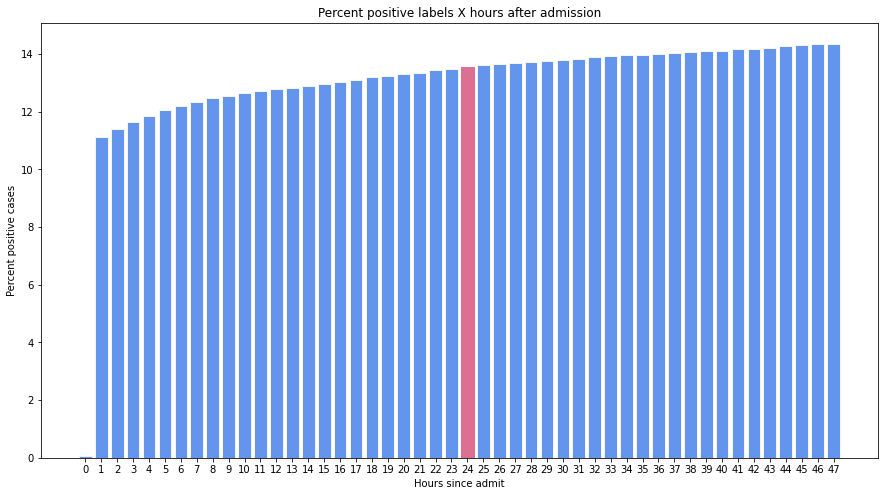

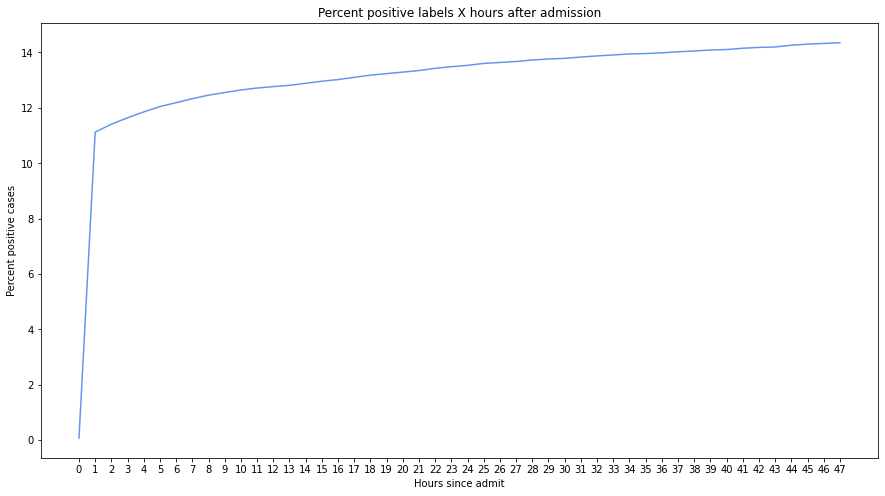

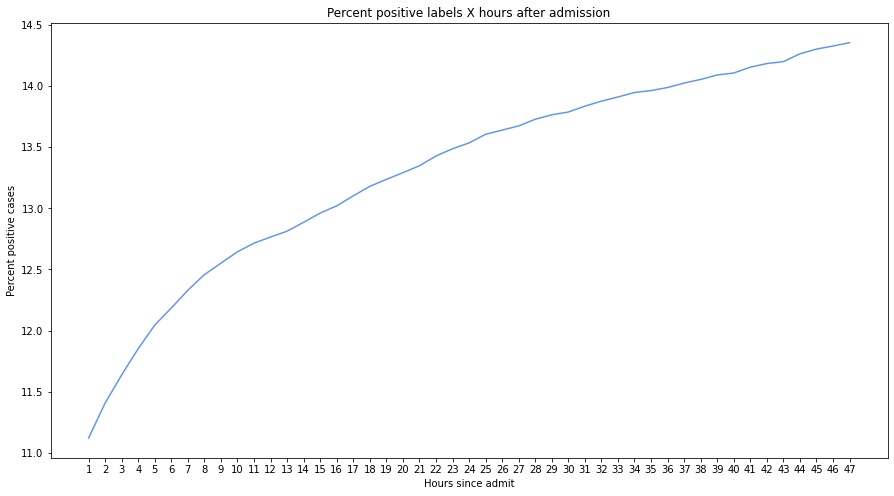

In [35]:
# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.bar(names, pos_perc, color='cornflowerblue', edgecolor='whitesmoke')
barlist[24].set_color('palevioletred')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases")
plt.title("Percent positive labels X hours after admission")
 
# Show graphic
plt.show()


# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_perc, color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases")
plt.title("Percent positive labels X hours after admission")
 
# Show graphic
plt.show()





# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_perc[1:], color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases")
plt.title("Percent positive labels X hours after admission")
 
# Show graphic
plt.show()

# Most recent level of care


In [ ]:
# get the adt table for events that happen between admit and X hours only
def get_adtX(X):
    # take only events that occur after admit but before the X hours mark
    adt_X = filtered_cohort_adt[(filtered_cohort_adt.effective_time_since_admit >= timedelta(hours=0))
                                 &
                                 (filtered_cohort_adt.effective_time_since_admit <= timedelta(hours=X))
                                &
                                (~filtered_cohort_adt.pat_lv_of_care.isnull())
                                ]

    # check out distribution of times
    print(adt_X.effective_time_since_admit.describe(), "\n")
    
    print("filtered_cohort_adt")
    describe_df(filtered_cohort_adt)
    print("\nadt_X")
    # check if we lost anyone - we're missing some
    describe_df(adt_X)


    print("\nmissing number of csns:")
    filtered_cohort_csns = filtered_cohort_adt.pat_enc_csn_id_coded.unique()
    adt_X_csns = adt_X.pat_enc_csn_id_coded.unique()
    print(len(filtered_cohort_csns) - len(adt_X_csns))
    
    # get these missing csns to manual check
    missing_csns = [x for x in filtered_cohort_csns if x not in adt_X_csns]
    
    return (adt_X, missing_csns)

In [ ]:
X=24
adt_X, missing_csns = get_adtX(X=24)

In [36]:
pos_count

# get the difference between one hour and the before
pos_count_diff = [pos_count[i+1] - pos_count[i] for i in range(len(pos_count)-1)]

In [37]:
# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(16,10))
# Create green Bars
barlist = plt.bar(names[:-1], pos_count_diff[1:], color=color1, edgecolor='white')
barlist[23].set_color(color2)

# Custom x axis

plt.xticks(names)
# plt.ylim([4000,6000])

plt.xlabel("Hours since initial inpatient admission", fontsize=16)
plt.ylabel("New positive cases", fontsize=16)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=14, rotation=0)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.savefig("traige_2019_positive_cases_noncumulative.png")
plt.show()

NameError: name 'color1' is not defined

<Figure size 1152x720 with 0 Axes>

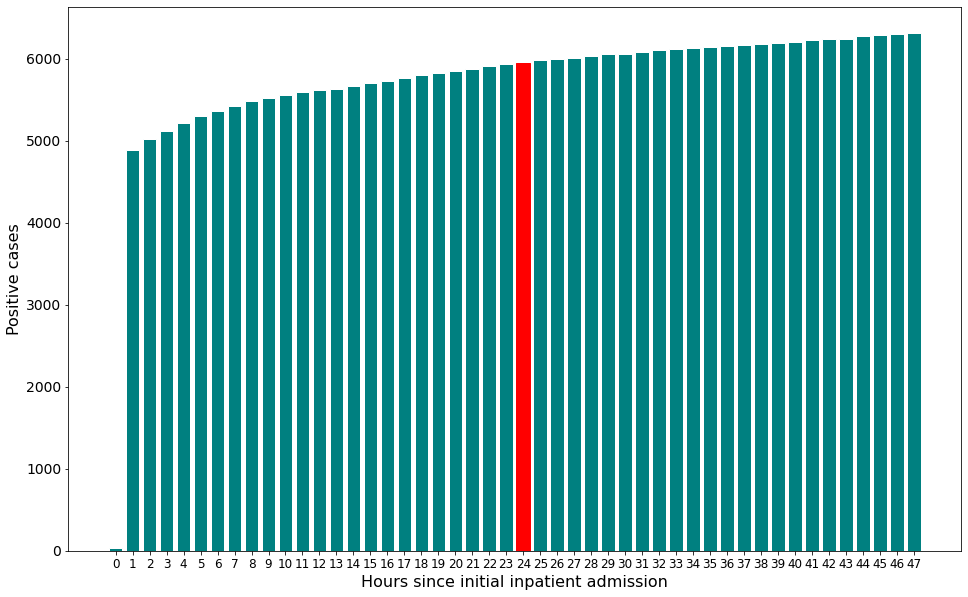

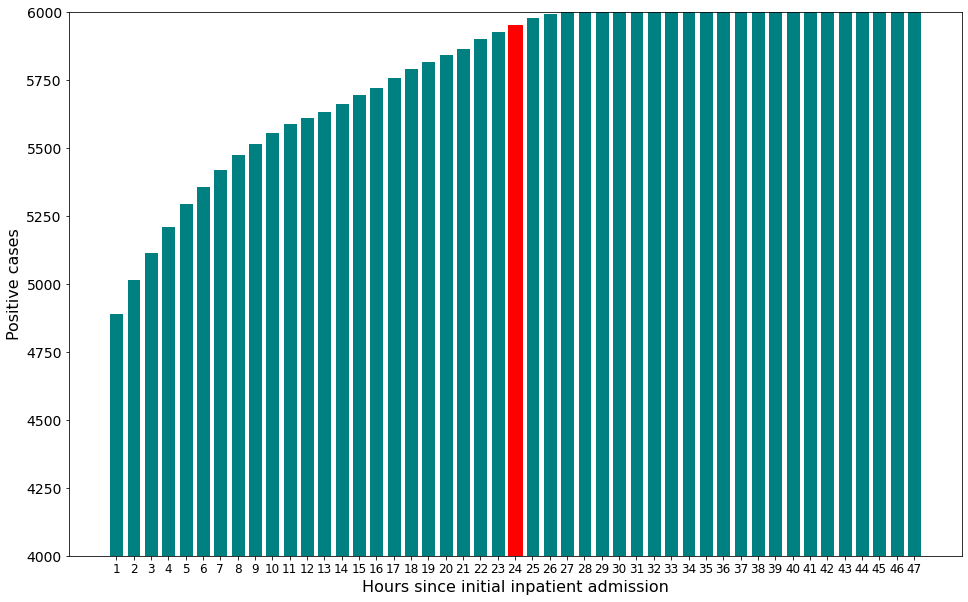

In [38]:
color1 = "teal"
color2 = "red"

# plot
# names = [x for x in range(48)]
# plt.figure(figsize=(10,12))
# # Create green Bars
# barlist = plt.barh(names, pos_count, color=color1, edgecolor='white')
# barlist[24].set_color(color2)

# # Custom x axis

# plt.yticks(names)

# plt.ylabel("Hours since admit", fontsize=16)
# plt.xlabel("Positive cases", fontsize=16)

# plt.yticks(fontsize=14, rotation=0)
# plt.xticks(fontsize=16, rotation=0)
# # plt.title("Positive labels X hours after admission")
 
# # Show graphic
# plt.savefig("traige_2019_postive_cases_horizontal.png", bbox_inches='tight')
# plt.show()



# plot
names = [x for x in range(48)]
plt.figure(figsize=(16,10))
# Create green Bars
barlist = plt.bar(names, pos_count, color=color1, edgecolor='white')
barlist[24].set_color(color2)

# Custom x axis

plt.xticks(names)

plt.xlabel("Hours since initial inpatient admission", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=14, rotation=0)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.savefig("traige_2019_positive_cases_vertical.png")
plt.show()



# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(16,10))
# Create green Bars
barlist = plt.bar(names, pos_count[1:], color=color1, edgecolor='white')
barlist[23].set_color(color2)

# Custom x axis

plt.xticks(names)
plt.ylim([4000,6000])

plt.xlabel("Hours since initial inpatient admission", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)

plt.xticks(fontsize=12, rotation=0)
plt.yticks(fontsize=14, rotation=0)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.savefig("traige_2019_positive_cases_vertical.png")
plt.show()


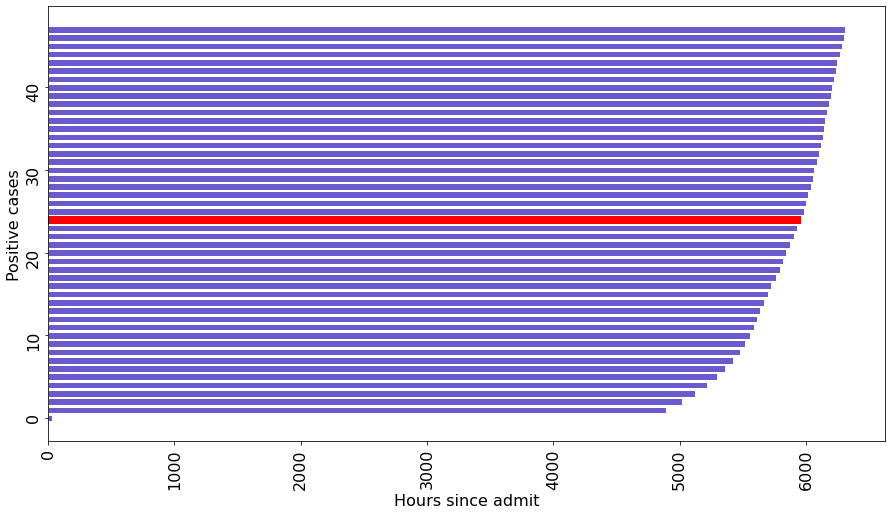

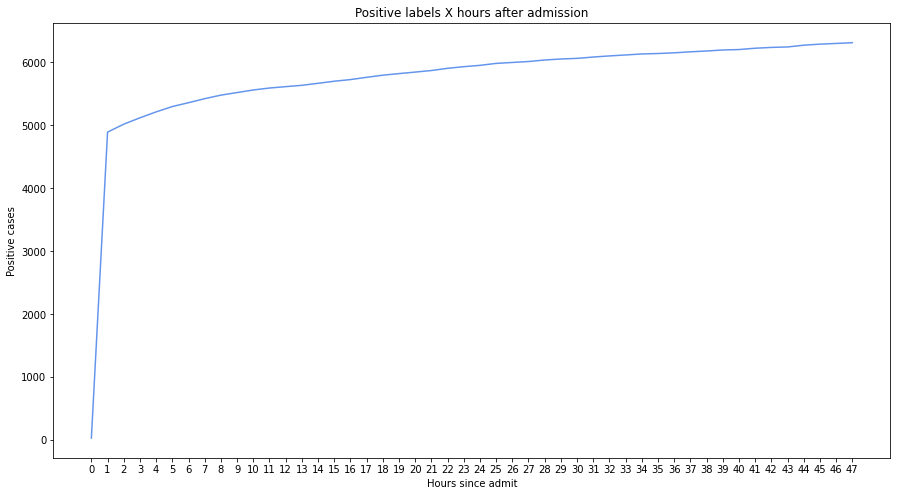

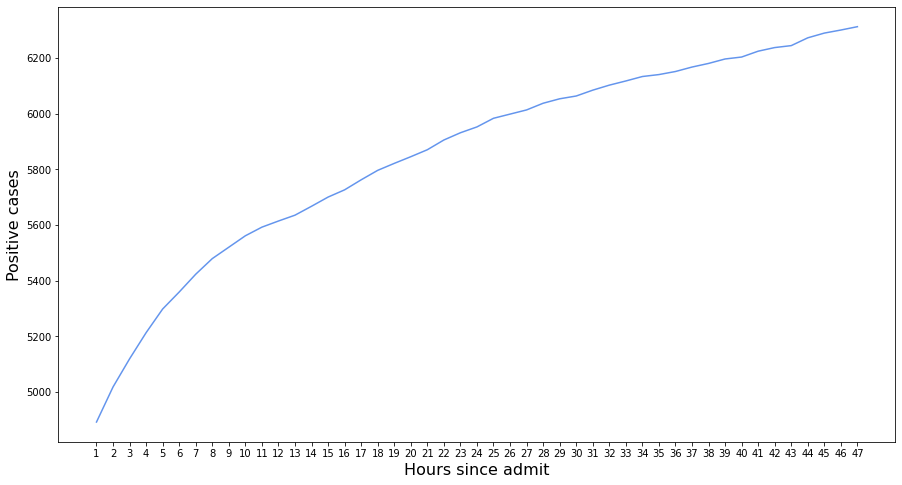

In [39]:
# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.barh(names, pos_count, color='slateblue', edgecolor='white')
barlist[24].set_color('r')

# Custom x axis

# plt.xticks(names)
plt.xlabel("Hours since admit", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)
plt.xticks(fontsize=16, rotation=90)
plt.yticks(fontsize=16, rotation=90)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.show()


# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_count, color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Positive cases")
plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.show()



# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.plot(names, pos_count[1:], color='cornflowerblue')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit", fontsize=16)
plt.ylabel("Positive cases", fontsize=16)
# plt.title("Positive labels X hours after admission")
 
# Show graphic
plt.show()

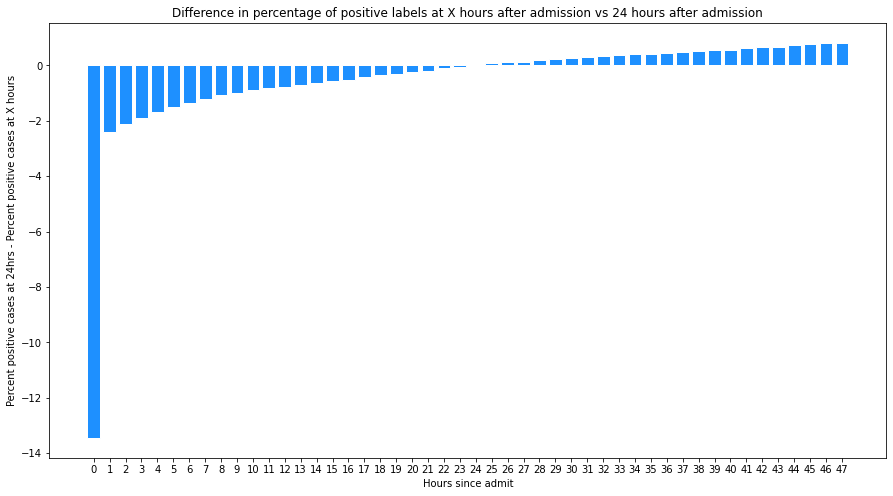

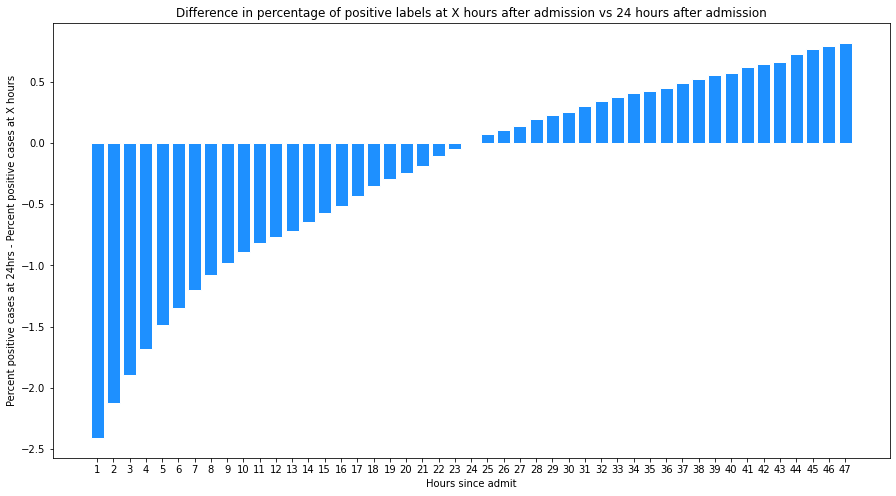

In [41]:
perc24 = pos_perc[24]
perc24

diffs = pos_perc - perc24
diffs

# plot
names = [x for x in range(48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.bar(names, diffs, color='dodgerblue', edgecolor='white')
# barlist[24].set_color('crimson')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases at 24hrs - Percent positive cases at X hours")
plt.title("Difference in percentage of positive labels at X hours after admission vs 24 hours after admission")
 
# Show graphic
plt.show()



# plot
names = [x for x in range(1,48)]
plt.figure(figsize=(15,8))
# Create green Bars
barlist = plt.bar(names, diffs[1:], color='dodgerblue', edgecolor='white')
# barlist[24].set_color('crimson')

# Custom x axis

plt.xticks(names)
plt.xlabel("Hours since admit")
plt.ylabel("Percent positive cases at 24hrs - Percent positive cases at X hours")
plt.title("Difference in percentage of positive labels at X hours after admission vs 24 hours after admission")
 
# Show graphic
plt.show()

# Check most recent labels 

Look at most recent labels to get the transfers for each hour.

In [5]:
recent_file = "../../OutputTD/1_cohort/1_4_recent_labels.csv"
cohort_file = "../../OutputTD/1_cohort/1_4_cohort.csv"

recent_labels = pd.read_csv(recent_file)
cohort = pd.read_csv(cohort_file)

In [14]:
cohort.head()

cohort.pat_enc_csn_id_coded.nunique()
recent_labels.pat_enc_csn_id_coded.nunique()

# keep only the csns in our final cohort
cohort_labels = recent_labels.loc[recent_labels.pat_enc_csn_id_coded.isin(cohort.pat_enc_csn_id_coded)]

print(cohort_labels.pat_enc_csn_id_coded.nunique())
cohort_labels

43980


,pat_enc_csn_id_coded,label_0hr_recent,label_0hr_recent_time_since_admit,label_1hr_recent,label_1hr_recent_time_since_admit,label_2hr_recent,label_2hr_recent_time_since_admit,label_3hr_recent,label_3hr_recent_time_since_admit,label_4hr_recent,...,label_20hr_recent,label_20hr_recent_time_since_admit,label_21hr_recent,label_21hr_recent_time_since_admit,label_22hr_recent,label_22hr_recent_time_since_admit,label_23hr_recent,label_23hr_recent_time_since_admit,label_24hr_recent,label_24hr_recent_time_since_admit
0,131176042095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0 days 22:05:00,0.0,0 days 22:05:00
1,131064611420,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,...,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00,1.0,0 days 10:43:00
2,131072326078,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,...,1.0,0 days 14:50:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00,1.0,0 days 20:47:00
3,131178712824,1.0,0 days,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,0 days 00:00:00,1.0,...,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00,1.0,0 days 14:58:00
4,131211945620,0.0,0 days,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,0 days 00:00:00,0.0,...,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00,0.0,0 days 09:42:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
44054,131166246836,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0 days 07:22:00,0.0,0 days 07:22:00,0.0,0 days 07:22:00,0.0,0 days 07:22:00,0.0,0 days 07:22:00
44055,131223679698,NaN,NaN,0.0,0 days 00:01:00,0.0,0 days 00:01:00,1.0,0 days 02:25:00,1.0,...,1.0,0 days 06:00:00,1.0,0 days 06:00:00,1.0,0 days 06:00:00,1.0,0 days 06:00:00,1.0,0 days 06:00:00
44056,131164768205,0.0,0 days,0.0,0 days 00:00:00,0.0,0 days 01:44:00,0.0,0 days 01:44:00,0.0,...,0.0,0 days 06:03:00,0.0,0 days 06:03:00,0.0,0 days 06:03:00,0.0,0 days 06:03:00,0.0,0 days 06:03:00
44057,131240586606,0.0,0 days,0.0,0 days 00:47:00,0.0,0 days 01:53:00,0.0,0 days 01:53:00,0.0,...,0.0,0 days 11:46:00,0.0,0 days 11:46:00,0.0,0 days 11:46:00,0.0,0 days 11:46:00,0.0,0 days 11:46:00


In [16]:
# compute the label switches for each hour
def compute_switch(X):
    current_label = "label_{}hr_recent".format(X)
    prev_label = "label_{}hr_recent".format(X-1)
    
    switch = cohort_labels[current_label] - cohort_labels[prev_label]
    return(switch)

In [22]:
# get the switch label for each hour
switch_labels = cohort_labels[['pat_enc_csn_id_coded']]

for X in range(1,25):
    colname = "label_switch_{}hr".format(X)
    
    switch_labels[colname] = compute_switch(X)

switch_labels = switch_labels.set_index('pat_enc_csn_id_coded')
switch_labels

<ipython-input-22-2d340dced9a9>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  switch_labels[colname] = compute_switch(X)


,label_switch_1hr,label_switch_2hr,label_switch_3hr,label_switch_4hr,label_switch_5hr,label_switch_6hr,label_switch_7hr,label_switch_8hr,label_switch_9hr,label_switch_10hr,...,label_switch_15hr,label_switch_16hr,label_switch_17hr,label_switch_18hr,label_switch_19hr,label_switch_20hr,label_switch_21hr,label_switch_22hr,label_switch_23hr,label_switch_24hr
pat_enc_csn_id_coded,,,,,,,,,,,,,,,,,,,,,
131176042095,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
131064611420,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131072326078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131178712824,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131211945620,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
131166246836,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131223679698,NaN,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
131164768205,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
# compute positive switch counts for each columns (0 --> 1) switch_label == 1
pos_counts = (switch_labels == 1).sum(axis=0)

# compute negative switch counts (1 --> 0) switch_label == -1
neg_counts = (switch_labels == -1).sum(axis=0)

counts = pd.DataFrame(list(zip(pos_counts,neg_counts)),
                     columns=['positive', 'negative'],
                      index=pos_counts.index
                     )

counts

,positive,negative
label_switch_1hr,96,45
label_switch_2hr,111,53
label_switch_3hr,99,51
label_switch_4hr,88,59
label_switch_5hr,82,56
label_switch_6hr,62,58
label_switch_7hr,62,47
label_switch_8hr,57,51
label_switch_9hr,41,49
label_switch_10hr,41,50


In [33]:
savefile = "../../OutputTD/5_results_analysis/5_4_pos_neg_switch_count_per_hour.csv"
counts.to_csv(savefile, index=True)